In [2]:
import os
import pandas as pd
import numpy as np
import pip
# visualization 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

# store serialized object locally
import pickle 

import datetime as dt
from datetime import timedelta 
from datetime import date

# import plotly for candlestick charts
!pip install plotly --quiet 
import plotly
from plotly import graph_objects as go

# stock data api
# from iexfinance.stocks import Stock
# from iexfinance.stocks import get_historical_data
import quandl as ql
import yfinance as yf

# find optimal ARIMA parameters
import pmdarima.arima as pmd
from pmdarima.arima import auto_arima

# Stats tools for performing stationarity tests and visualization of time series
import statsmodels 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import sklearn as sk
# from sklearn.model_selection import GridSearchCV
# model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings 


In [3]:
print('matplotlib ver: %s'%matplotlib.__version__)
print('pandas version: %s'%pd.__version__)
print('numpy version: %s'%np.__version__)
print('scikit learn version: %s' %sk.__version__)
print('plotly version: %s' % plotly.__version__)
print('statsmodels ver: %s'%statsmodels.__version__)

matplotlib ver: 3.2.2
pandas version: 1.0.5
numpy version: 1.19.5
scikit learn version: 0.23.1
plotly version: 4.14.3
statsmodels ver: 0.11.1


In [4]:
style.use('ggplot')
# quandl api key activation
ql.ApiConfig.api_key = open("ql_api_token.txt").read()


### Objectives:
- Create a model that can forecast future price of a stock based on the historical price data available. 
- Accomplish this by imputing the future values and determining if it is a buy or a sell based on the forecasting of 2 business quarters of the company.  

In [5]:
# Start: 1st trading day in 2014 
start = dt.datetime(2014,1,2)
# latest close date 
end = date.today()
# Using quandl api to retrieve historical data on ticker MSFT (Microsoft)
eod_msft_data = ql.get('EOD/MSFT', start_date=start, end_date=end)
# eod_msft_data.head()
eod_msft_data.tail()
# Free EOD data is limited to end of 2017

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2017-12-21,86.05,86.1000,85.400,85.50,17990745.0,0.0,1.0,82.563848,82.611822,81.940182,82.036130,17990745.0
2017-12-22,85.40,85.6300,84.920,85.51,14145841.0,0.0,1.0,81.940182,82.160864,81.479628,82.045725,14145841.0
2017-12-26,85.31,85.5346,85.030,85.40,9891237.0,0.0,1.0,81.853828,82.069328,81.585171,81.940182,9891237.0
2017-12-27,85.65,85.9800,85.215,85.71,14678025.0,0.0,1.0,82.180053,82.496684,81.762676,82.237622,14678025.0
2017-12-28,85.90,85.9300,85.550,85.72,10594344.0,0.0,1.0,82.419925,82.448710,82.084105,82.247217,10594344.0


In [6]:
# Check for any null values in dataset 
eod_msft_data.isnull().values.any() 

False

In [7]:
# trim down dataframe to necessary columns
adj_close_msft_2017 = eod_msft_data[['Volume','Adj_Close']] 
adj_close_msft_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2014-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Volume     1006 non-null   float64
 1   Adj_Close  1006 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


In [8]:
# Get remaining data from Yahoo Finance
ticker = 'MSFT'
# if os.path.exists(ticker+'.pickle'):
#     with open(ticker+'.pickle', 'rb') as handle:
#     file_ = pickle.load(handle)
#     print(file_)
# else:
#     msft_yf= yf.download(ticker,start='2018-01-02',end='2019-12-28')
#     with open(ticker+'.pickle', 'wb') as handle:
#         pickle.dump(msft_yf, handle)

msft_yf= yf.download(ticker,start='2018-01-02',end='2019-12-28')

[*********************100%***********************]  1 of 1 completed


We're excluding data points from 2020 as the market had entered unchartered territory in February 2020 since the market had never encountered a situation like this before. The market saw a major sell off in March with the S&P500 plunging by ~30%  

In [9]:
msft_yf.columns = ['Open','High','Low','Close','Adj_Close','Volume']
msft_yf.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.194328,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.576843,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.303658,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.336464,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.422516,22113000


In [10]:
# Check for any null values in dataset 
msft_yf.isnull().values.any() 

False

In [11]:
# Splice dataframe for volume and adjusted close prices
adj_close_msft_2019 = msft_yf[['Adj_Close','Volume']]
adj_close_msft_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2018-01-02 to 2019-12-27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj_Close  501 non-null    float64
 1   Volume     501 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 11.7 KB


In [12]:
# concatenate dataframes
adj_close_msft_merged = adj_close_msft_2017.append(adj_close_msft_2019)
adj_close_msft_merged.describe()

,Volume,Adj_Close
count,1.507000e+03,1507.000000
mean,2.984572e+07,70.604946
std,1.448462e+07,33.312663
min,7.425603e+06,30.286770
25%,2.128605e+07,42.228968
50%,2.664930e+07,58.776510
75%,3.408979e+07,97.605789
max,2.025224e+08,156.932251


Training was designated as all adjusted close data prior to 2019. Adjusted close price was used here because this price is adjusted for the dividends and stock splits that it may have occurred over the selected period of time.

In [13]:
# test/train data split
train = adj_close_msft_merged['Adj_Close'][:'2018-12-31']
test = adj_close_msft_merged['Adj_Close']['2019-01-01':]
train.describe()

count    1257.000000
mean       59.256589
std        22.565603
min        30.286770
25%        41.156288
50%        50.999474
75%        71.541842
max       111.988419
Name: Adj_Close, dtype: float64

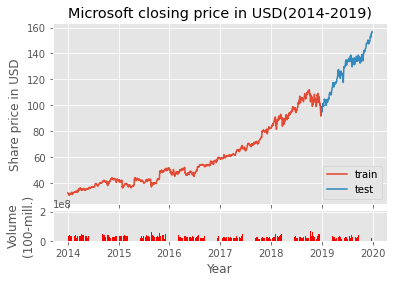

In [14]:
# Plot training and testing data 
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot( train, label='train')
ax1.plot( test, label='test')
ax2.bar(x=adj_close_msft_merged.index,height=adj_close_msft_merged['Volume'],color='red')
ax1.set_title('Microsoft closing price in USD(2014-2019)')
ax1.set(ylabel='Share price in USD')
# Number of transactions in a given timestamp 
ax2.set(ylabel='Volume\n(100-mill.)')
ax2.set(xlabel='Year')
leg1 = ax1.legend(loc='lower right')
ax1.add_artist(leg1)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [15]:
# Daily prices including highs and lows with volume for hockeystick graph
full_msft_df = eod_msft_data[['Open','High','Low','Close','Adj_Close','Volume']].append(msft_yf)
# If a stock underwent a split, you'd have to create a new dataset based on the Adjusted Close values.
full_msft_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2014-01-02 to 2019-12-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1507 non-null   float64
 1   High       1507 non-null   float64
 2   Low        1507 non-null   float64
 3   Close      1507 non-null   float64
 4   Adj_Close  1507 non-null   float64
 5   Volume     1507 non-null   float64
dtypes: float64(6)
memory usage: 82.4 KB


### Feature Engineering 
#### Technical indicators (features) 
In technical stock analysis, various indicators are used in order to guage the next move in the price of an equity. Some of the most common indicators are: 
- Moving averages (Simple, Exponential): The intersection of moving averages usually hold value in determining the overall trend of the price movement.  eg. Golden Cross, death cross
- Bollinger bands: Crossing of price above or below the bands act as indicators of whether the stock maybe overbought or oversold. 
- Relative strength index (RSI): A popular momentum oscillator. Measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
- Trailing and Forward P/E ratio :  If a company is rapidly growing, the forward P/E could be much higher than the trailing P/E. If it sells a piece of its business or undergoes a large scale restructuring, forward earnings could temporarily nosedive. <br>
(Source: [Investopedia](https://www.investopedia.com/articles/investing/041013/differences-between-forward-pe-and-trailing-pe.asp))

In [16]:
symbol_info = yf.Ticker("msft").info
symbol_info['pegRatio'], symbol_info['trailingPE'], symbol_info['forwardPE']

(1.87, 34.69065, 31.427158)

##### Calculating RSI 
The standard is to use 14 periods to calculate the initial RSI value.

In [17]:
def calc_ticker_rs(df,price_col='adj close'):
    d_ = df[price_col].diff()
    pos_ = d_.clip(lower=0)
    neg_ = -1*d_.clip(upper=0)
    ema_up = pos_.ewm(com=13, adjust=False).mean()
    ema_down = neg_.ewm(com=13, adjust=False).mean()
    rel_str = ema_up/ema_down
    return rel_str


##### Stochastic oscillator 

In [18]:
def stochastic_osc(df, col_name='adj close'):
    
    high_14 = df[col_name].rolling(14).max()
    low_14 = df[col_name].rolling(14).min()
    osc = 100-(df[col_name] - low_14)*100/(high_14 - low_14)
    return osc
# stochastic = np.vectorize(stochastic_osc)

#### MACD 

In [19]:
def ma_conv(df):
    macd = df['12d-ema'] - df['26d-ema']
    macd_sig = macd.ewm(span=9, min_periods=9).mean()
    return (macd_sig - macd)

##### Calculating Moving average cross-overs



In [21]:
# def ma_cross(df):
#     #To-Do: still deciding on how to use crossover points 
    

In [22]:
full_msft_df['50d-sma'] = full_msft_df['Adj_Close'].rolling(50).mean()
full_msft_df['100d-sma'] = full_msft_df['Adj_Close'].rolling(100).mean()
full_msft_df['200d-sma'] = full_msft_df['Adj_Close'].rolling(200).mean()
full_msft_df['12d-ema'] = full_msft_df['Adj_Close'].ewm(span=12, min_periods=12).mean()
full_msft_df['26d-ema'] = full_msft_df['Adj_Close'].ewm(span=26, min_periods=26).mean()
full_msft_df['returns'] = full_msft_df['Adj_Close'].pct_change()
full_msft_df['macd'] = ma_conv(full_msft_df)
full_msft_df['dvol_pct_chng'] = full_msft_df['Volume'].pct_change()
full_msft_df['rsi'] = 100 - (100/(1+calc_ticker_rs(full_msft_df,price_col='Adj_Close')))
full_msft_df['%k'] = stochastic_osc(full_msft_df,col_name='Adj_Close')
full_msft_df[100:200]

# To-Do: Create function to automatically generate moving average columns

,Open,High,Low,Close,Adj_Close,Volume,50d-sma,100d-sma,200d-sma,12d-ema,26d-ema,returns,macd,dvol_pct_chng,rsi,%k
Date,,,,,,,,,,,,,,,,
2014-05-28,40.14,40.19,39.82,40.01,35.142882,25711500.0,34.953521,33.560041,NaN,35.093961,34.955788,-0.004479,-0.023135,-0.017167,52.965338,35.589671
2014-05-29,40.15,40.35,39.91,40.34,35.432739,19888200.0,34.972179,33.594790,NaN,35.146080,34.991132,0.008248,-0.031929,-0.226486,56.738180,6.944326
2014-05-30,40.45,40.97,40.25,40.94,35.959750,34567600.0,35.006262,33.641563,NaN,35.271260,35.062907,0.014874,-0.068267,0.738096,62.610647,0.000000
2014-06-02,40.95,41.09,40.68,40.79,35.827997,18504300.0,35.019217,33.684593,NaN,35.356912,35.119599,-0.003664,-0.077781,-0.464692,60.403150,11.194030
2014-06-03,40.60,40.68,40.25,40.29,35.388821,18068900.0,35.026354,33.728860,NaN,35.361821,35.139548,-0.012258,-0.050193,-0.023530,53.617078,48.507463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-10,45.60,46.12,43.95,44.03,38.912745,51978146.0,40.069195,38.491844,NaN,40.516121,40.557152,-0.039695,0.227186,0.509825,36.959755,100.000000
2014-10-13,43.82,44.56,43.49,43.65,38.576909,37100207.0,40.087810,38.523198,NaN,40.217780,40.410467,-0.008630,0.303074,-0.286235,35.075484,100.000000
2014-10-14,43.87,44.38,43.56,43.73,38.647611,38120558.0,40.098879,38.557455,NaN,39.976216,40.279885,0.001833,0.331245,0.027503,35.817346,97.444089


In [43]:

# Training dataset using candlestick format with rangeslider to zoom into prices in a given time period. 

fig = go.Figure(data=[go.Candlestick(x=full_msft_df.index,
                      open=full_msft_df['Open'],
                      close=full_msft_df['Close'],
                      high=full_msft_df['High'],
                      low=full_msft_df['Low'],
                      increasing_line_color='cyan',
                      decreasing_line_color='gray',
                      name='Adjusted closing price'
                     )])

fig.add_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["50d-sma"],mode='lines',name="Simple Moving average (50 day)")
    )
fig.add_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["100d-sma"],mode='lines',name="Simple Moving average (100 day)")
    )
fig.add_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["200d-sma"],mode='lines',name="Simple Moving average (200 day)")
    )

fig.update_layout(
    title='MSFT price in the last 3 years prior to 2019 as candlestick chart',
    yaxis_title='Adjusted Close Price/USD')

fig.show()



In [44]:
from plotly.subplots import make_subplots

# Plotting technical indicators 
fig1 = make_subplots(rows=3, cols=1)
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["macd"],mode='lines',name="MACD"),row=1,col=1
    )
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["%k"],mode='lines',name="Stochastic %K"),row=2,col=1
    )
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["rsi"],mode='lines',name="Relative Strength Index"),row=3,col=1
    )
fig1.show()

In [ ]:
import plotly.io as pio
# save interactive plot as html 
pio.write_html(fig, file='/img/candlestick-chart.html', auto_open=True)

#### Creating labels for training 

In [ ]:
#To-Do use unsupervised learning to generate labels

### Properties of time series


In [ ]:
# PLOT ACF 
lag_acf = plot_acf(train,lags=50, title='Adjusted close price')


The height of each spike shows the value of the autocorrelation function for the lag.
<br>
The autocorrelation with lag zero always equals 1, because this represents the autocorrelation between each term and itself. Price and price with lag zero are the same variable.
<br>
Each spike that rises above or falls below the dashed lines is considered to be statistically significant.
In this example, the spikes are statistically significant for lags up to 50. This means that the MSFT stock prices are highly correlated with each other. In other words, when the price of MSFT stock rises, it tends to continue rising. When the price of MSFT stock falls, it tends to continue falling.

In [ ]:
#PLOT PACF
lag_pacf = plot_pacf(train, lags=40, title='Adjusted closing price')

Looking strictly for what directly affects the series. According to this plot, we can see lags 1,5,17,25,34 have significant correlation prior to differencing.  

### Testing for stationarity
<b>H0</b>: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt. My null hypothesis is that the series is non-stationary. 

<b>H1</b>: My alternative hypothesis is that the time series is stationary.



In [ ]:
# Differencing required?
print("Orders of differencing required: ",pmd.ndiffs(train))

In [ ]:
# test timeseries for stationarity using the Augmented Dickey-Fuller test
adf_test_result = adfuller(train)
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

Here, the p-value (0.97) is greater than 0.05 so we cannot reject the Null hypothesis and has a unit root. And that the series has some time dependent features as well. 
For time series analysis, we will need to separate trend and seasonality from the time series.

### Decomposing a time series 
Decomposing a time series means separating it into its constituent components, which are usually a trend component and an irregular component, and if it is a seasonal time series, a seasonal component.
To estimate the trend component of a non-seasonal time series that can be described using an additive model, it is common to use a smoothing method, such as calculating the simple moving average of the time series.

#### Differencing the time series
Most time series models assume that each point is independent of one another. Therefore, its important that the statistical properties of a system do not change over time. 

In [ ]:
# First order differencing  
train_first_diff = train.values[:-2] - train.values[1:-1]

# train['first_order_diff'] = train_first_diff
print(train_first_diff[:5])

print('mean: %s' %train_first_diff.mean())
fig = plt.plot(train_first_diff)
plt.axhline(y=train_first_diff.mean(), color='black')
plt.show()

In [ ]:
# Differencing required?
print("Orders of differencing required: ",pmd.ndiffs(train_first_diff))

In [ ]:
# Test stationarity 
adf_test_result = adfuller(train_first_diff)
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

Based on the outputs from the Augmented Dickey-Fuller test, we can see that the p-value is near zero which is less than the critical value we had set for the series (0.05). We can reject the null hypothesis and accept that the series is stationary after differencing the series. This differenced series can be used for our ARMA model. 

In [ ]:
fdiff_lag_pacf = plot_pacf(train_first_diff,lags=50,title='First differenced price series')

In [ ]:
fdiff_lag_acf = plot_acf(train_first_diff, lags=50, title="differenced series acf")
_ = plt.xlabel('Lags')
_ = plt.ylabel('ACF')

Looking at this plot, we can see that lags 31 and 41 have significant correlation which means the series is still not stationary.

In [ ]:
# Log transform training data
log_train_diff = np.log(train).diff()
# Compare train and differenced log(train) series
fig, ax = plt.subplots(1,1)
ax.plot(train,color='blue')
ax.plot(log_train_diff, color='red')
ax.legend(['train', 'log_train_diff'])
plt.show()

In [ ]:
# Test stationarity 
adf_test_result = adfuller(log_train_diff.dropna())
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: ' , adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
# moving average differencing
ma_3d = train.rolling(window=3, center=False).mean() 
diff_ma_3d = ma_3d.diff()
diff_ma_3d_no_nan = diff_ma_3d.dropna()
# print(diff_ma_3d_no_nan)
# plt.plot(diff_ma_12d)
plt.plot(diff_ma_3d_no_nan)
plt.axhline(diff_ma_3d_no_nan.mean(),color='gray')
plt.xlabel('Year')
plt.show()

In [ ]:
# Differencing required?
print("Orders of differencing required: ",pmd.ndiffs(diff_ma_3d_no_nan))

In [ ]:
adf_test_result = adfuller(diff_ma_3d.dropna())
print('ADF Statistic: ' , adf_test_result[0])
print('p-value: ' , adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

Based on the outputs from the Augmented Dickey-Fuller test, we can see that the p-value is near zero which is less than the critical value we had set for the series (0.05). As we did before, we can reject the null hypothesis and accept that the series is stationary after differencing the series. This differenced series can be used for our ARMA model. 

In [ ]:
ma_diff_acf = plot_acf(diff_ma_3d.dropna())
_ = plt.xlabel('lags')
_ = plt.ylabel('ACF')

In [ ]:
ma_diff_pacf = plot_pacf(diff_ma_3d.dropna())
_ = plt.xlabel('lags')
_ = plt.ylabel('PACF')

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(train,color='blue')
ax.plot(diff_ma_3d, color='red')
ax.legend(['train', 'ma_train_diff'])
# plt.ylabel('transformed values')
plt.xlabel('Year')
plt.show()

In [ ]:
# differencing log train and exponential moving average of series (12d)
ewma_12d_logtrain_diff = np.log(train) - train.ewm(span=3, min_periods=3).mean()
ewma_12d_logtrain_diff_nonan = ewma_12d_logtrain_diff.dropna()
# fig = plt.plot(ewma_12d_logtrain_diff)
fig, ax = plt.subplots(1,1)
ax.plot(train,color='blue')
ax.plot(ewma_12d_logtrain_diff_nonan, color='red')
ax.legend(['train', 'ewma_12d_logtrain_diff'])
plt.show()

In [ ]:
adf_test_result = adfuller(ewma_12d_logtrain_diff_nonan)
print('ADF Statistic: ' , adf_test_result[0])
print('p-value: ' , adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
logtrain_ma12_diff = np.log(train) - train.rolling(window=3, center=True).mean() 
fig = plt.plot(logtrain_ma12_diff)
plt.axhline(y=logtrain_ma12_diff.mean(),color='gray')
plt.show()


In [ ]:
# Transform using exponential moving average for a log transformed series
log_ewma_ = np.log(train).ewm(span=3, min_periods=3).mean()
fig, ax = plt.subplots(1,1)
ax.plot(train,color='blue')
ax.plot(log_ewma_, color='red')
ax.legend(['train', 'ewma_12d_logtrain_diff'])
plt.show()

In [ ]:
adf_test_result = adfuller(log_ewma_.dropna())
print('ADF Statistic: ', adf_test_result[0])
print('p-value: ', adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

To-Do: 
1. Write functions that will:
<br>
    a. try out all these different combinations, and plot them into a grid format. 
    <br>
    b. Perform ADF test on the resulting series
    <br>
    c. Return an array of series names as candidates for the ARIMA model.

# Building the ARIMA model 

Auto-Regressive (p) -> Number of autoregressive terms. 
<br>
Integrated (d) -> Number of nonseasonal differences needed for stationarity.
<br>
Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
<br>
In the Auto-ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components. It works similarly like hyperparameter tuning techniques to find the optimal value of p, d, and q with different combinations and the final values would be determined with the lower AIC, BIC parameters taking into consideration.
<br>
Here, we are trying with the p, d, q values ranging from 0 to 5 to get better optimal values from the model.

Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

#### Optimal order for the ARIMA model using auto_arima function


In [ ]:
# Find optimal parameters for ARIMA 
order_params_train = auto_arima(train_first_diff,start_p=1,seasonal=False,max_p=3,max_d=3,max_q=5, information_criterion='aic')
order_params_train.summary()


Rejecting this series because the AIC score is too high. 

In [ ]:
order_params_ = auto_arima(diff_ma_3d_no_nan,start_p=1,max_p=3,max_d=3,max_q=5, information_criterion='aic',scoring_args={'mse'})
order_params_.summary()

After testing the parameters on the model in the cells below, it was found that the order of (3,0,2) had the lowest AIC score and was therefore chosen as the order for the price forecasts going forward.
<br>
**Important note:** Generally, when choosing the optimal order for ARIMA models, we select the model with the lowest AIC, more parameters will increase the AIC score and thus penalize the model. A small AIC value does not a guarantee that the model will have a good performance on unseen data, or that its squared estimate of errors(SSE) will be small. 
<br>
Source: https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

In [ ]:
print(diff_ma_3d_no_nan.index)
# ARIMA for 3-day moving average differenced time series
ma3_arima_model = ARIMA(endog=diff_ma_3d_no_nan, order=(3,0,2))
ma3_model_res = ma3_arima_model.fit()
print(ma3_model_res.summary())

In [ ]:
# Forecasting based on moving average 
y_hat = ma3_model_res.predict()
y_hat.index = pd.to_datetime(y_hat.index,format='%Y-%m-%d')
_ = plt.plot(y_hat)
_ = plt.plot(diff_ma_3d)
plt.legend(['forecast','differenced series'],loc='lower left')
plt.show() 

In order to see how accurately forecasts the price of the stock, we will need to invert the transformations that we had performed on the series (diff_ma_3d) prior fitting the model. 

In [ ]:
# convert back to original series
_ = plt.plot(diff_ma_3d)
revert_diff = diff_ma_3d + ma_3d  
ma_3d_reversed=revert_diff.rolling(window=3).sum().shift(-2)
_ = plt.plot(revert_diff, c='blue')
_ = plt.plot(diff_ma_3d, c='red')
_ = plt.plot(ma_3d, c='green')
_ = plt.plot(ma_3d_reversed, c='gold')
_ = plt.plot(train, c='magenta')
_ = plt.legend(['orig diffed series','revert_diff','orig ma_3d','orig training','reversed ma_3d'])
plt.show()

In [ ]:
forecasted_train = y_hat + ma_3d 
forecasted_train.index = pd.to_datetime(forecasted_train.index)
_ = plt.plot(forecasted_train['2018-08-31':], ls='--')
_ = plt.plot(train['2018-08-31':])
_ = plt.ylabel('Price (USD)')
_ = plt.xlabel('Date')
_ = plt.xticks(rotation='45')
_ = plt.legend(['forecasted series','training series'],loc='lower left')
plt.show()

What we want to do now is : 
1. Apply model on test series via moving windows using current p,d,q. Add test data 1 day at a time.  Or use the predicted values instead for a quarter of the year (90 days)
2. Validate this model using RMSE, MSE


In [ ]:
warnings.filterwarnings("ignore")

# Loop that predicts one day at a time and retrains on new data point.  
for i in range(30):
    ma_3d = forecasted_train.rolling(window=3, center=False).mean() 
    diff_ma_3d = ma_3d.diff()
    diff_ma_3d_no_nan = diff_ma_3d.dropna()
    ma3_model = ARIMA(endog=diff_ma_3d_no_nan, order=(3,0,2))
    new_model_res = ma3_model.fit()
    raw_forecasted_train = new_model_res.predict(start=len(diff_ma_3d_no_nan),
                                      end=len(diff_ma_3d_no_nan)+1)
    to_append = pd.Series(dict(zip(test.index,(raw_forecasted_train))),dtype='object')
    to_append[0]+= forecasted_train[-1]
    to_append[1]+= to_append[0]
    forecasted_train = forecasted_train.append(to_append)


In [ ]:
# Replace index in forecasted series
future_prices_ = forecasted_train['2019-01-02':]
future_prices_.index = test.index[:len(future_prices_)]
# future_prices_.index

In [ ]:
# Comparison of series 
_ = plt.plot(future_prices_, c='cyan',ls='--')
_ = plt.plot(forecasted_train['2018-09-01':'2018-12-31'],c='magenta',ls='--')
_ = plt.plot(train['2018-09-01':'2018-12-31'],c='blue')
_ = plt.plot(test[:len(future_prices_)],c='gray')
_ = plt.xlabel('Date')
_ = plt.ylabel('Price (USD)')
_ = plt.legend(['Forecasted series based on previous predicted prices', 'Forecasted series based on training data', 'Actual timeseries data from test dataset' ])
plt.show()

#### Model Performance 

In [ ]:
mean_sq_err = mean_squared_error(future_prices_, test[:len(future_prices_)])
print("mean squared error with respect to test : ", mean_sq_err)

Let's try something different. What if we plug in the real world data per diem and see how that changes the accuracy of the forecasting. 

In [ ]:
# Add end of day close price (test) instead of predicted price
train_copy = train
predicted_val_list = []
for i in range(25):
    ma_3d = train_copy.rolling(window=3, center=False).mean() 
    diff_ma_3d = ma_3d.diff()
    diff_ma_3d_no_nan = diff_ma_3d.dropna()
    ma3_model = ARIMA(endog=diff_ma_3d_no_nan, order=(3,0,2))
    new_model_res = ma3_model.fit()
    raw_predict = new_model_res.predict(end=len(train_copy)+1)
    forecasted_val = raw_predict.iloc[-1]+train_copy.iloc[-1]
    predicted_val_list.append(forecasted_val)
    train_copy = train_copy.append(pd.Series(test[i]))


In [ ]:
index_ = pd.to_datetime(test.index,format='%Y-%m-%d')
predicted_series = pd.Series(predicted_val_list,index=index_[:len(predicted_val_list)])

In [ ]:
_ = plt.plot(predicted_series, c='cyan',ls='--')
_ = plt.plot(full_msft_df['Adj_Close'][len(train)-25:len(train)+25],c='blue')
_ = plt.xlabel('Date')
_ = plt.ylabel('Price (USD)')
_ = plt.legend(['Forecasted series based on previous predicted prices', 
                'Actual timeseries dataset' ])
plt.show()

In [ ]:
mean_sq_err = mean_squared_error(predicted_series, test[:len(predicted_series)])
print("mean squared error with respect to test : ", mean_sq_err)

Sample code for K-means is listed below that should be tried out if we decide to go with unsupervised clustering

In [ ]:
# # Import the necessary packages
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import Normalizer
# from sklearn.cluster import KMeans# Define a normalizer
# normalizer = Normalizer()# Create Kmeans model
# kmeans = KMeans(n_clusters = 10,max_iter = 1000)# Make a pipeline chaining normalizer and kmeans
# pipeline = make_pipeline(normalizer,kmeans)# Fit pipeline to daily stock movements
# pipeline.fit(movements)labels = pipeline.predict(movements)
# from sklearn.decomposition import PCA # Reduce the data
# reduced_data = PCA(n_components = 2).fit_transform(norm_movements)# Define step size of mesh
# h = 0.01# Plot the decision boundary
# x_min,x_max = reduced_data[:,0].min()-1, reduced_data[:,0].max() + 1
# y_min,y_max = reduced_data[:,1].min()-1, reduced_data[:,1].max() + 1
# xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))# Obtain labels for each point in the mesh using our trained model
# Z = kmeans.predict(np.c_[xx.ravel(),yy.ravel()])# Put the result into a color plot
# Z = Z.reshape(xx.shape)# Define color plot
# cmap = plt.cm.Paired# Plotting figure
# plt.clf()
# plt.figure(figsize=(10,10))
# plt.imshow(Z,interpolation = ‘nearest’,extent=(xx.min(),xx.max(),yy.min(),yy.max()),cmap = cmap,aspect = ‘auto’,origin = ‘lower’)plt.plot(reduced_data[:,0],reduced_data[:,1],’k.’,markersize = 5)# Plot the centroid of each cluster as a white X
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:,0],centroids[:,1],marker = ‘x’,s = 169,linewidths = 3,color = ‘w’,zorder = 10)plt.title(‘K-Means clustering on stock market movements (PCA-Reduced data)’)
# plt.xlim(x_min,x_max)
# plt.ylim(y_min,y_max)
# plt.show()

The cluster formation with PCA reduction is different from the cluster formation without PCA reduction. The cons of PCA reduction is some details are lost. The results are not very accurate. The pros of PCA reduction is less computational power and easy visualization.